In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import re
import nltk
import os
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words
from tqdm import tqdm

from wordcloud import WordCloud

# Download necessary NLTK packages
# nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
nltk.data.path

['C:\\Users\\filip/nltk_data',
 'c:\\Users\\filip\\anaconda3\\envs\\DMML\\nltk_data',
 'c:\\Users\\filip\\anaconda3\\envs\\DMML\\share\\nltk_data',
 'c:\\Users\\filip\\anaconda3\\envs\\DMML\\lib\\nltk_data',
 'C:\\Users\\filip\\AppData\\Roaming\\nltk_data',
 'C:\\nltk_data',
 'D:\\nltk_data',
 'E:\\nltk_data']

In [3]:
df = pd.read_csv('../dataset/DataSetKaggle/Resume/Resume.csv')
df.head()

ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   
3  27018550           HR SPECIALIST       Summary    Dedica...   
4  17812897           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category  
0  <div class="fontsize fontface vmargins hmargin...       HR  
1  <div class="fontsize fontface vmargins hmargin...       HR  
2  <div class="fontsize fontface vmargins hmargin...       HR  
3  <div class="fontsize fontface vmargins hmargin...       HR  
4  <div class="fontsize fontface vmargins hmargin...       HR

In [4]:
df.drop(columns = ['Resume_html'], inplace = True)
df.head()

ID                                         Resume_str Category
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...       HR
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...       HR
2  33176873           HR DIRECTOR       Summary      Over 2...       HR
3  27018550           HR SPECIALIST       Summary    Dedica...       HR
4  17812897           HR MANAGER         Skill Highlights  ...       HR

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          2484 non-null   int64 
 1   Resume_str  2484 non-null   object
 2   Category    2484 non-null   object
dtypes: int64(1), object(2)
memory usage: 58.3+ KB


In [6]:
# From the data visualization, we noticed that there is an empty resume in the dataset
df.select_dtypes(include='object').apply(lambda col: col.str.strip() == '').sum()

Resume_str    1
Category      0
dtype: int64

In [7]:
df = df[df['Resume_str'].str.strip() != '']

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2483 entries, 0 to 2483
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          2483 non-null   int64 
 1   Resume_str  2483 non-null   object
 2   Category    2483 non-null   object
dtypes: int64(1), object(2)
memory usage: 77.6+ KB


In [9]:
word_count = df['Resume_str'].apply(lambda x: len(str(x).split())) #For each resume, it contains the number of words

desc = word_count.describe()
q1 = word_count.quantile(0.25)
q3 = word_count.quantile(0.75)
iqr = q3 - q1

print("Statistics of Word Count in Resumes:")
print(f"Minimum      : {desc['min']}")
print(f"1st Quartile : {q1}")
print(f"Median       : {desc['50%']}")
print(f"3rd Quartile : {q3}")
print(f"Maximum      : {desc['max']}")
print(f"Mean         : {desc['mean']:.2f}")
print(f"IQR (Q3 - Q1): {iqr}")

Statistics of Word Count in Resumes:
Minimum      : 113.0
1st Quartile : 651.0
Median       : 757.0
3rd Quartile : 933.0
Maximum      : 5190.0
Mean         : 811.65
IQR (Q3 - Q1): 282.0


### Preprocessing

In [10]:
# Get the list of valid English words
english_words = set(words.words())

# Get a list of stop word
stop_words = set(nltk.corpus.stopwords.words('english'))

# Initialize the stemmer
stemmer = PorterStemmer()

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

In [11]:
def preprocess_text(text, remove_stopword=True, use_lemmatization=True, use_stemming=False):
    """
    Preprocesses the text: 
    - Converts to lowercase
    - Removes punctuation
    - Remove underscore
    - Tokenizes
    - Removes tokens with numbers
    - Removes stopwords
    - Applies lemmatization or stemming based on parameters
    """
    
    text = text.lower()                         # Convert to lowercase
    text = re.sub(r'[^\w\s]', ' ', text)        # Remove all punctuation  
    text = re.sub(r'_', ' ', text)              # Remove underscore
    text = re.sub('\s+', ' ', text)             # Remove multiple spaces
    
    tokens = word_tokenize(text) # Tokenize the text

    processed_tokens = []
    
    for token in tokens:
        # Remove words containing numbers
        if any(char.isdigit() for char in token):
            continue

        # Dictionary filtering
        # if token not in english_words:
        #    continue

        # Remove stopwords
        if remove_stopword and (token in stop_words):
            continue

        if use_lemmatization:
            token = lemmatizer.lemmatize(token)
        if use_stemming:
            token = stemmer.stem(token)

        processed_tokens.append(token)
    
    return ' '.join(processed_tokens)


In [12]:
def preprocess_text_with_progress(df, column_name, **kwargs):

    tqdm.pandas(desc="Processing Resumes")  # Enable tqdm for Pandas
    return df[column_name].progress_apply(lambda x: preprocess_text(x, **kwargs))

In [13]:
parameter_sets = [
    {"remove_stopword": True, "use_lemmatization": True, "use_stemming": True},
    {"remove_stopword": True, "use_lemmatization": True, "use_stemming": False},
    {"remove_stopword": True, "use_lemmatization": False, "use_stemming": True},
    {"remove_stopword": False, "use_lemmatization": False, "use_stemming": False}
]

In [14]:
for params in parameter_sets:
    # Create a copy of the original DataFrame
    df_copy = df.copy()

    # Apply preprocessing with the current parameter combination
    df_copy['Resume_str'] = preprocess_text_with_progress(df_copy, 'Resume_str', **params)

    # Define the folder where CSV files will be saved
    output_folder = "processed_data"
    
    # Ensure the folder exists (create it if necessary)
    os.makedirs(output_folder, exist_ok=True)

    # Generate the full path for saving the file
    if params["use_lemmatization"] and not params["use_stemming"]:
        filename = os.path.join(output_folder, "Resume_proc_lemm.csv")
    elif params["use_lemmatization"] and params["use_stemming"]: 
        filename = os.path.join(output_folder, "Resume_proc_lemm_stem.csv")
    elif not params["use_lemmatization"] and params["use_stemming"]:
        filename = os.path.join(output_folder, "Resume_proc_stem.csv")
    else:
        filename = os.path.join(output_folder, "Resume_proc.csv")
    
    # Save the DataFrame to the specified folder
    df_copy.to_csv(filename, index=False)

    print(f"Processed DataFrame saved as: {filename}")

Processing Resumes: 100%|██████████| 2483/2483 [00:47<00:00, 52.66it/s]


Processed DataFrame saved as: processed_data\Resume_proc_lemm_stem.csv


Processing Resumes: 100%|██████████| 2483/2483 [00:17<00:00, 140.58it/s]


Processed DataFrame saved as: processed_data\Resume_proc_lemm.csv


Processing Resumes: 100%|██████████| 2483/2483 [00:55<00:00, 44.84it/s]


Processed DataFrame saved as: processed_data\Resume_proc_stem.csv


Processing Resumes: 100%|██████████| 2483/2483 [00:08<00:00, 285.51it/s]


Processed DataFrame saved as: processed_data\Resume_proc.csv


### WordClouds

In [15]:
df_clouds = pd.read_csv("processed_data/Resume_proc_lemm.csv")

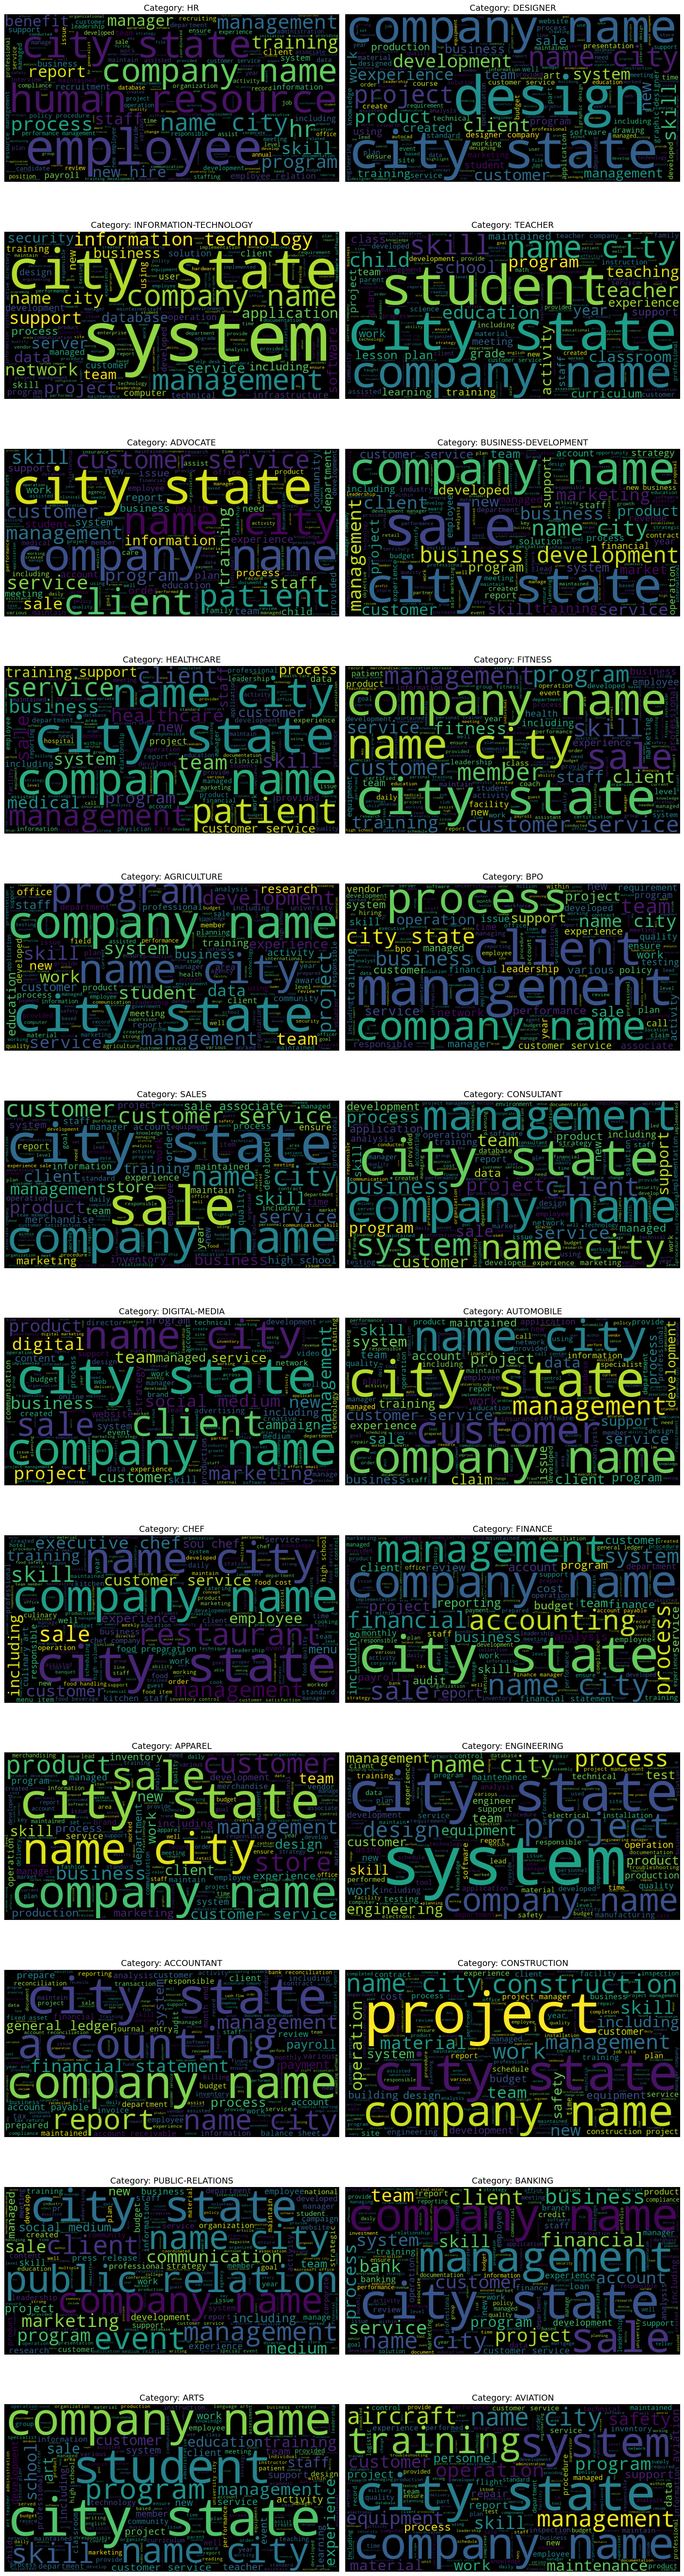

In [16]:
categories = df_clouds['Category'].unique()
n = len(categories)

cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(16, 5 * rows))
axes = axes.flatten()

for idx, category in enumerate(categories):
    text = " ".join(df_clouds[df_clouds['Category'] == category]['Resume_str'])
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

    axes[idx].imshow(wordcloud)
    axes[idx].set_title(f"Category: {category}", fontsize=14)
    axes[idx].axis('off')

plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
plt.show()